In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets

from keras.datasets import mnist
import timm

import numpy as np
import matplotlib.pyplot as plt

2025-07-27 19:54:39.845690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 19:54:42.377875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753660482.888490  574271 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753660482.976363  574271 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753660484.119478  574271 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def print_torch_info():
    print("PyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("Number of GPUs:", torch.cuda.device_count())
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("No CUDA-enabled GPU found.")

print_torch_info()

PyTorch version: 2.7.1+cu126
CUDA available: True
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 2080 Ti


In [4]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_resnet_34(device):
    model = models.resnet18(pretrained=True)
    model.to(device)
    model.eval()
    return model

def load_vit_base_patch16_224(device):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.to(device)
    return model


def get_dataloaders(batch_size=1):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


def train_model(model, train_loader, epochs=5, lr=1e-3, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            num_correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = num_correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    model.eval()
    return model


def fgsm_attack(image, epsilon, data_gradient):
    sign_gradient = data_gradient.sign()
    perturbed = image + epsilon*sign_gradient
    perturbed = torch.clamp(perturbed, 0, 1) #Guarantees all values are betewen 0 and 1
    return perturbed

def execute_fgsm(model, device, test_loader, epsilon, num_images=5):
    #Load Data
    image_count = 0
    incorrectly_classified = 0
    images_tried = 0
    initial_images = []
    perturbed_images = []
    corresponding_labels = []
    for images, labels in test_loader:
        images_tried += 1
        images, labels = images.to(device), labels.to(device)
        _, init_pred = model(images).max(1)
        if init_pred == labels:
            print("Image initially classified correctly as: ", init_pred.item())
            image_count += 1
            initial_images.append(images)
            images.requires_grad = True
            criterion = nn.CrossEntropyLoss()
            outputs = model(images)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()
            data_gradient = images.grad.data
            perturbed = fgsm_attack(images, epsilon, data_gradient)
            perturbed_images.append(perturbed)
            adv_outputs = model(perturbed)
            _, adv_pred = adv_outputs.max(1)
            print("Adversarial image classified as: ", adv_pred.item())
            if adv_pred != init_pred:
                incorrectly_classified += 1
            corresponding_labels.append((labels, adv_pred))
        if image_count == num_images:
            break
    print("Number of images tried: ", images_tried)
    try:
        print("Percentage of perturbed images incorrectly classified: ", (incorrectly_classified/image_count)*100)
    except ZeroDivisionError:
        print("Model did not correctly classify any images")
    return initial_images, perturbed_images, corresponding_labels

def visualize(orig, perturbed):
    inv_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    #orig_disp = inv_norm(orig.squeeze()).permute(1,2,0).cpu().detach().numpy()
    #pert_disp = inv_norm(perturbed.squeeze()).permute(1,2,0).cpu().detach().numpy()
    orig_disp = orig.squeeze().permute(1,2,0).cpu().detach().numpy()
    pert_disp = perturbed.squeeze().permute(1,2,0).cpu().detach().numpy()

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
    ax1.imshow(orig_disp)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(pert_disp)
    ax2.set_title('Perturbed')
    ax2.axis('off')
    plt.show()


In [5]:
device = get_device()
print(f"Using device: {device}")
train_loader, test_loader = get_dataloaders()
#model = load_resnet_34(device)
model = load_vit_base_patch16_224(device)
model = train_model(model, train_loader, epochs=1, lr=1e-3, device=device)
epsilon = 0.007
orig, perturbed, labels = execute_fgsm(model, device, test_loader, epsilon, num_images=5)



Using device: cuda
Epoch 1/1, Loss: 2.2080, Accuracy: 0.1765
Image initially classified correctly as:  7
Adversarial image classified as:  7
Image initially classified correctly as:  2
Adversarial image classified as:  9
Image initially classified correctly as:  1
Adversarial image classified as:  1
Image initially classified correctly as:  1
Adversarial image classified as:  2
Image initially classified correctly as:  1
Adversarial image classified as:  1
Number of images tried:  15
Percentage of perturbed images incorrectly classified:  40.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


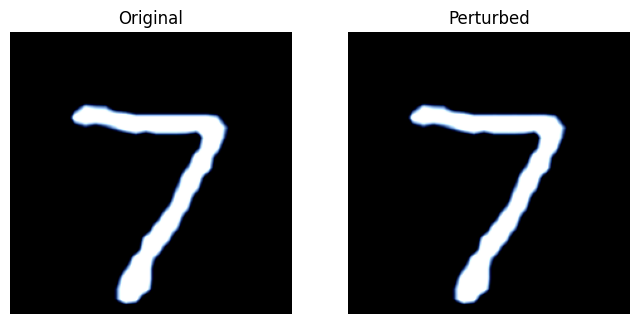

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original label:  7
Adversarial label:  8


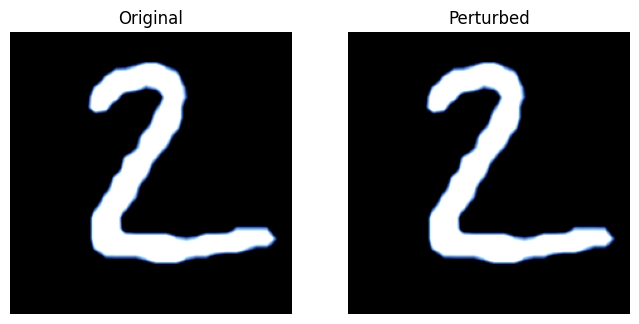

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original label:  2
Adversarial label:  4


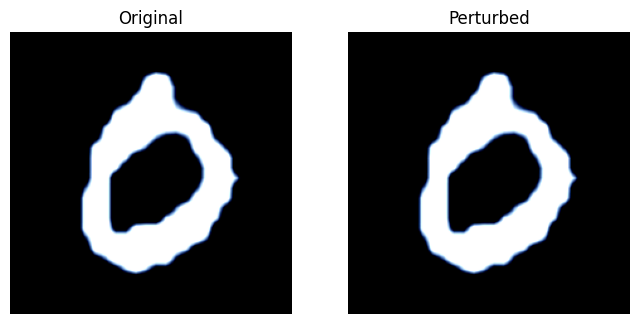

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original label:  0
Adversarial label:  8


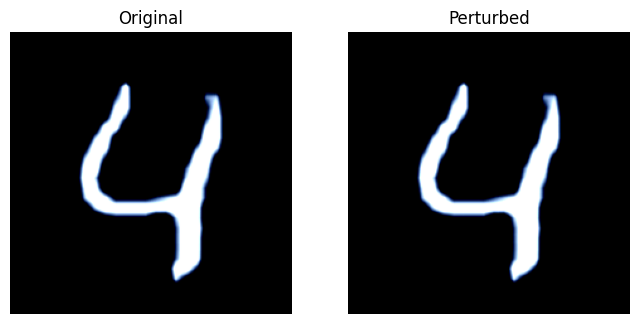

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Original label:  4
Adversarial label:  8


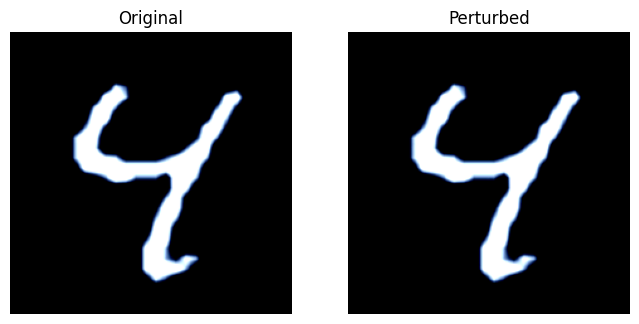

Original label:  4
Adversarial label:  8


In [22]:
if len(orig) != 0:
    for idx in range(len(orig)):
        visualize(orig[idx], perturbed[idx])
        print("Original label: ", labels[idx][0].item())
        print("Adversarial label: ", labels[idx][1].item())